# XGBoost for Price 1

## Introduction

    * Predict stock price in next month using XGBoost
    * Given prices and other features for the last N months, we do prediction for month N+1
    * Here we split 30 years of data into train(60%), dev(20%) and test(20%)
    * Here we scale the train set to have mean 0 and variance 1, and apply the same transformation to dev and test sets
    * Here for the past N values for the dev set, we scale them to have mean 0 and variance 1, and do prediction on them
    * Instead of using the same mean and variance to do scaling for train, dev and test sets, we scale the train set to have mean 0 and var 1, and then whenever we do prediction on dev or test set we scale the previous N values to also have mean 0 and var 1 (ie. use the means and variances of the previous N values to do scaling. We do this for both feature columns and target columns)

In [1]:
import math
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import time

from datetime import date
from matplotlib import pyplot as plt
from pylab import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm_notebook
from xgboost import XGBRegressor

%matplotlib inline

#### Input ######

test_size = 0.2                # proportion of dataset to be used as test set
cv_size = 0.2                  # proportion of dataset to be used as cross-validation set
N = 3                          # for feature at day t, we use lags from t-1, t-2, ..., t-N as features

n_estimators = 100             # Number of boosted trees to fit. default = 100
max_depth = 3                  # Maximum tree depth for base learners. default = 3
learning_rate = 0.1            # Boosting learning rate (xgb’s “eta”). default = 0.1
min_child_weight = 1           # Minimum sum of instance weight(hessian) needed in a child. default = 1
subsample = 1                  # Subsample ratio of the training instance. default = 1
colsample_bytree = 1           # Subsample ratio of columns when constructing each tree. default = 1
colsample_bylevel = 1          # Subsample ratio of columns for each split, in each level. default = 1
gamma = 0                      # Minimum loss reduction required to make a further partition on a leaf node of the tree. default=0
model_seed = 100
fontsize = 14
ticklabelsize = 14

# Functions

In [2]:
def get_mov_avg_std(df, col, N):
    """
    Given a dataframe, get mean and std dev at timestep t using values from t-1, t-2, ..., t-N.
    Inputs
        df         : dataframe. Can be of any length.
        col        : name of the column you want to calculate mean and std dev
        N          : get mean and std dev at timestep t using values from t-1, t-2, ..., t-N
    Outputs
        df_out     : same as df but with additional column containing mean and std dev
    """
    mean_list = df[col].rolling(window = N, min_periods=1).mean() # len(mean_list) = len(df)
    std_list = df[col].rolling(window = N, min_periods=1).std()   # first value will be NaN, because normalized by N-1
    
    # Add one timestep to the predictions
    mean_list = np.concatenate((np.array([np.nan]), np.array(mean_list[:-1])))
    std_list = np.concatenate((np.array([np.nan]), np.array(std_list[:-1])))
    
    # Append mean_list to df
    df_out = df.copy()
    df_out[col + '_mean'] = mean_list
    df_out[col + '_std'] = std_list
    
    return df_out

def scale_row(row, feat_mean, feat_std):
    """
    Given a pandas series in row, scale it to have 0 mean and var 1 using feat_mean and feat_std
    Inputs
        row      : pandas series. Need to scale this.
        feat_mean: mean  
        feat_std : standard deviation
    Outputs
        row_scaled : pandas series with same length as row, but scaled
    """
    # If feat_std = 0 (this happens if adj_close doesn't change over N days), 
    # set it to a small number to avoid division by zero
    feat_std = 0.001 if feat_std == 0 else feat_std
    
    row_scaled = (row-feat_mean) / feat_std
    
    return row_scaled

def get_mape(y_true, y_pred): 
    """
    Compute mean absolute percentage error (MAPE)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def train_pred_eval_model(X_train_scaled, \
                          y_train_scaled, \
                          X_test_scaled, \
                          y_test, \
                          col_mean, \
                          col_std, \
                          seed=100, \
                          n_estimators=100, \
                          max_depth=3, \
                          learning_rate=0.1, \
                          min_child_weight=1, \
                          subsample=1, \
                          colsample_bytree=1, \
                          colsample_bylevel=1, \
                          gamma=0):
    '''
    Train model, do prediction, scale back to original range and do evaluation
    Use XGBoost here.
    Inputs
        X_train_scaled     : features for training. Scaled to have mean 0 and variance 1
        y_train_scaled     : target for training. Scaled to have mean 0 and variance 1
        X_test_scaled      : features for test. Each sample is scaled to mean 0 and variance 1
        y_test             : target for test. Actual values, not scaled.
        col_mean           : means used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        col_std            : standard deviations used to scale each sample of X_test_scaled. Same length as X_test_scaled and y_test
        seed               : model seed
        n_estimators       : number of boosted trees to fit
        max_depth          : maximum tree depth for base learners
        learning_rate      : boosting learning rate (xgb’s “eta”)
        min_child_weight   : minimum sum of instance weight(hessian) needed in a child
        subsample          : subsample ratio of the training instance
        colsample_bytree   : subsample ratio of columns when constructing each tree
        colsample_bylevel  : subsample ratio of columns for each split, in each level
        gamma              : 
    Outputs
        rmse               : root mean square error of y_test and est
        mape               : mean absolute percentage error of y_test and est
        est                : predicted values. Same length as y_test
    '''

    model = XGBRegressor(seed=model_seed,
                         n_estimators=n_estimators,
                         max_depth=max_depth,
                         learning_rate=learning_rate,
                         min_child_weight=min_child_weight,
                         subsample=subsample,
                         colsample_bytree=colsample_bytree,
                         colsample_bylevel=colsample_bylevel,
                         gamma=gamma)
    
    # Train the model
    model.fit(X_train_scaled, y_train_scaled)
    
    # Get predicted labels and scale back to original range
    est_scaled = model.predict(X_test_scaled)
    est = est_scaled * col_std + col_mean

    # Calculate RMSE
    rmse = math.sqrt(mean_squared_error(y_test, est))
    mape = get_mape(y_test, est)
    
    return rmse, mape, est

# Data Input

In [3]:
df = pd.read_csv("../Data/XGBoost_All_Pre_3_M.csv")
df.loc[:, 'Date'] = pd.to_datetime(df['Date'],format='%Y-%m-%d')
df.columns = [str(x).lower().replace(' ', '_') for x in df.columns]
df['month'] = df['date'].dt.month
df.sort_values(by='date', inplace=True, ascending=True)
df.drop(["sent^_","sent"],axis=1,inplace=True)
df.head()

,date,price1,price2,price3,price4,price5,yr2,yr3,yr4,yr5,...,pce_defl:_nondble,pce_defl:_service,ahe:_goods,ahe:_const,ahe:_mfg,consumer_expect,finan_h1,marco_h1,bw,month
0,1969-12-01,93.333,86.870,80.967,75.074,69.950,-1.108279,-1.859145,-2.604972,-3.644531,...,27.7995,18.3032,3.40,4.51,3.15,78.3,1.078593,0.641486,NaN,12
1,1970-01-01,93.607,87.098,81.405,75.202,70.288,-1.520870,-3.004423,-5.578124,-6.409783,...,27.9188,18.3809,3.41,4.54,3.16,77.1,1.101297,0.666907,1.597037,1
2,1970-02-01,92.786,85.959,79.285,73.154,67.907,-0.982875,-2.443723,-3.805612,-4.529114,...,28.0357,18.4596,3.43,4.56,3.17,75.8,1.120442,0.662006,3.501664,2
3,1970-03-01,92.854,85.608,79.562,73.532,68.355,-0.520513,-1.186517,-2.867803,-3.604665,...,28.0382,18.5488,3.45,4.60,3.19,74.3,1.155210,0.661063,1.089143,3
4,1970-04-01,93.065,86.141,79.695,73.733,68.585,0.369531,-0.363624,-1.907979,-3.379245,...,28.2254,18.6378,3.47,4.66,3.19,72.7,1.232648,0.668466,1.930754,4


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 361 entries, 0 to 360
Columns: 305 entries, date to month
dtypes: datetime64[ns](1), float64(303), int64(1)
memory usage: 863.0 KB


Text(0, 0.5, 'USD')

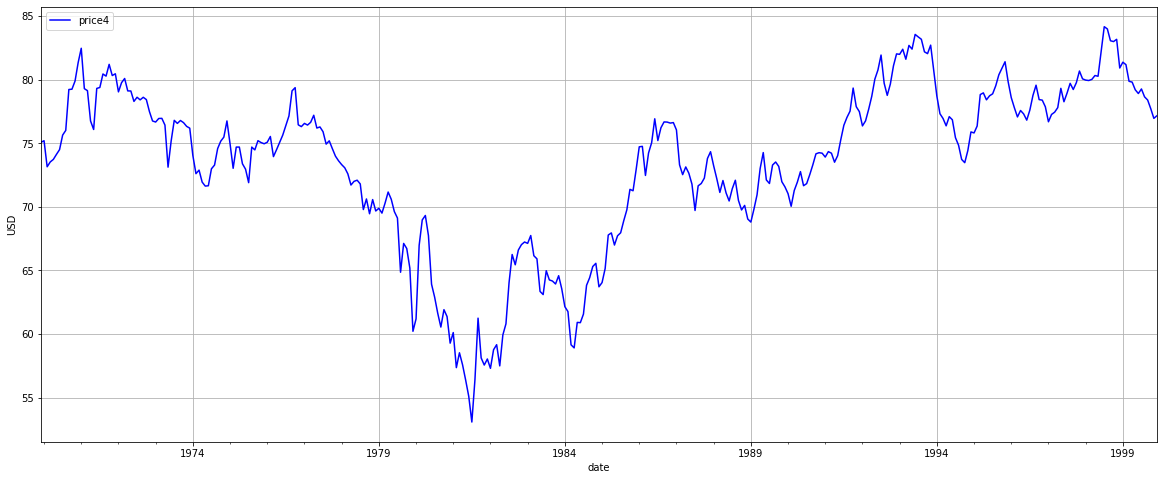

In [5]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 20, 8 # width 10, height 8
ax = df.plot(x='date', y='price4', style='b-', grid=True)
ax.set_xlabel("date")
ax.set_ylabel("USD")

# Feature Engineering

We will generate the following features:
* Mean 'price1' of each month
* Use PCA to compress correlation

Now we use lags up to N number of days to use as features.

In [6]:
df['id'] = [x for x in list(range(len(df)))]
pca=PCA(n_components=1)
df_factor = df.iloc[:,12:-1]
df_factor.drop(['month'],axis=1,inplace=True)
count = 0
while(((df_factor.corr()>0.8).sum()-1).sum()>0):
    count +=1
    i = 0
    while(not ((df_factor.corr()>0.8).sum()-1)[i]>0):
        i+=1
    temp_l = list((df_factor.corr()>0.8).iloc[i,:])
    pca_l =[]
    for j in range(len(temp_l)):
        if temp_l[j]:
            pca_l.append(df_factor.columns[j])
    pca_l=list(set(pca_l))
    temp_df=pca.fit_transform(df_factor.loc[:,pca_l])
    df_factor.drop(pca_l,axis=1,inplace=True)
    df_factor["PCA"+str(count)] = temp_df
    print(str(count)+" ",end="")

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 

In [7]:
df.index = df['date']
df_factor.index = df['date']
df = pd.concat([df.loc[:,["price1","date","month","id"]],df_factor],axis=1).iloc[1:,:]
df.head()

,price1,date,month,id,f2,f3,f4,f7,f8,r15-r11,...,PCA19,PCA21,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,93.607,1970-01-01,1,1,1.83830,-0.10564,0.32657,-1.14040,-0.66347,58.205291,...,0.171695,-46.915623,-93.839304,-673.370023,2.260169,3.775922,156.037655,129.932035,937.231400,-1979.208338
1970-02-01,92.786,1970-02-01,2,2,0.97842,0.75592,0.30007,-0.52714,1.48290,24.116042,...,0.324605,45.339311,-84.216928,-470.194919,2.059131,4.633414,156.011911,129.432451,-460.422190,-1932.310250
1970-03-01,92.854,1970-03-01,3,3,0.30629,-0.15847,0.92243,0.44476,0.10178,61.059852,...,0.465517,45.102946,-35.966270,-459.082040,1.110353,2.700414,155.845618,129.000640,320.758904,-1857.385075
1970-04-01,93.065,1970-04-01,4,4,1.16570,-0.33656,-0.84470,0.32372,0.64264,137.386472,...,0.823795,20.694534,-62.576508,-412.101931,1.090828,3.166520,156.319319,129.592373,2044.912922,-1777.831484
1970-05-01,93.438,1970-05-01,5,5,0.71366,1.77200,-0.80034,0.35286,3.00860,-3.124063,...,0.888251,17.498009,-51.482065,-300.972359,1.029808,1.802906,157.141961,130.984510,1409.554610,-1783.784638


In [8]:
# # Get mean of adj_close of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'adj_close':'mean'})
# df_gb = df_gb.rename(columns={'adj_close':'adj_close_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# # Merge to main df
# shift_range = [x+1 for x in range(2)]

# for shift in tqdm_notebook(shift_range):
#     train_shift = df[merging_keys + lag_cols].copy()
    
#     # E.g. order_day of 0 becomes 1, for shift = 1.
#     # So when this is merged with order_day of 1 in df, this will represent lag of 1.
#     train_shift['order_day'] = train_shift['order_day'] + shift
    
#     foo = lambda x: '{}_lag_{}'.format(x, shift) if x in lag_cols else x
#     train_shift = train_shift.rename(columns=foo)

#     df = pd.merge(df, train_shift, on=merging_keys, how='left') #.fillna(0)
    
# del train_shift
    
# df

In [9]:
# # Get mean of volume of each month
# df_gb = df.groupby(['month'], as_index=False).agg({'volume':'mean'})
# df_gb = df_gb.rename(columns={'volume':'volume_mean'})
# df_gb

# # Merge to main df
# df = df.merge(df_gb, 
#               left_on=['month'], 
#               right_on=['month'],
#               how='left').fillna(0)

# df.head()

# Get mean and std dev at t using values from t-1, ..., t-N

In [10]:
cols_list = [
"price1",
]

for col in cols_list:
    df = get_mov_avg_std(df, col, N)
df.head()

,price1,date,month,id,f2,f3,f4,f7,f8,r15-r11,...,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,price1_mean,price1_std
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,93.607,1970-01-01,1,1,1.83830,-0.10564,0.32657,-1.14040,-0.66347,58.205291,...,-93.839304,-673.370023,2.260169,3.775922,156.037655,129.932035,937.231400,-1979.208338,NaN,NaN
1970-02-01,92.786,1970-02-01,2,2,0.97842,0.75592,0.30007,-0.52714,1.48290,24.116042,...,-84.216928,-470.194919,2.059131,4.633414,156.011911,129.432451,-460.422190,-1932.310250,93.607000,NaN
1970-03-01,92.854,1970-03-01,3,3,0.30629,-0.15847,0.92243,0.44476,0.10178,61.059852,...,-35.966270,-459.082040,1.110353,2.700414,155.845618,129.000640,320.758904,-1857.385075,93.196500,0.580535
1970-04-01,93.065,1970-04-01,4,4,1.16570,-0.33656,-0.84470,0.32372,0.64264,137.386472,...,-62.576508,-412.101931,1.090828,3.166520,156.319319,129.592373,2044.912922,-1777.831484,93.082333,0.455645
1970-05-01,93.438,1970-05-01,5,5,0.71366,1.77200,-0.80034,0.35286,3.00860,-3.124063,...,-51.482065,-300.972359,1.029808,1.802906,157.141961,130.984510,1409.554610,-1783.784638,92.901667,0.145480


# Split into train, dev and test set

In [11]:
# Get sizes of each of the datasets
num_cv = int(cv_size*len(df))
num_test = int(test_size*len(df))
num_train = len(df) - num_cv - num_test
print("num_train = " + str(num_train))
print("num_cv = " + str(num_cv))
print("num_test = " + str(num_test))

# Split into train, cv, and test
train = df[:num_train]
cv = df[num_train:num_train+num_cv]
train_cv = df[:num_train+num_cv]
test = df[num_train+num_cv:]
print("train.shape = " + str(train.shape))
print("cv.shape = " + str(cv.shape))
print("train_cv.shape = " + str(train_cv.shape))
print("test.shape = " + str(test.shape))

num_train = 216
num_cv = 72
num_test = 72
train.shape = (216, 79)
cv.shape = (72, 79)
train_cv.shape = (288, 79)
test.shape = (72, 79)


# Scaling

In [12]:
cols_to_scale = ["price1"]+list(df.columns[4:])

In [13]:
# Do scaling for train set
# Here we only scale the train dataset, and not the entire dataset to prevent information leak
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train[cols_to_scale])



# Convert the numpy array back into pandas dataframe
train_scaled = pd.DataFrame(train_scaled, columns=cols_to_scale)

train_scaled.index = train.index
train_scaled.head()

,price1,f2,f3,f4,f7,f8,r15-r11,cp_factor,smb,agric,...,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,price1_mean,price1_std
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,0.581750,1.338207,-0.051336,0.161338,-1.756015,-0.681703,1.043619,-0.229495,0.915076,0.044330,...,-0.697796,-1.344634,0.154385,0.783236,1.860517,1.825741,1.210952,-1.616344,NaN,NaN
1970-02-01,0.248393,0.652104,0.767358,0.139523,-1.051059,1.433992,0.277410,-0.318039,-0.862677,1.251270,...,-0.629945,-1.009568,0.111163,0.996953,1.860053,1.817308,-0.621051,-1.576066,0.593613,NaN
1970-03-01,0.276004,0.115808,-0.101538,0.651867,0.066163,0.072611,1.107780,-0.017497,-0.842054,-2.158877,...,-0.289711,-0.991241,-0.092819,0.515183,1.857049,1.810019,0.402898,-1.511718,0.424232,0.408340
1970-04-01,0.361678,0.801536,-0.270767,-0.802884,-0.072976,0.605741,2.823340,0.242956,-2.159546,-2.879979,...,-0.477350,-0.913764,-0.097016,0.631352,1.865604,1.820007,2.662867,-1.443396,0.377125,0.070163
1970-05-01,0.513129,0.440850,1.732885,-0.766365,-0.039479,2.937888,-0.334854,-0.503002,-1.596092,-1.761663,...,-0.399119,-0.730495,-0.110135,0.291493,1.880460,1.843506,1.830059,-1.448508,0.302578,-0.769702


In [14]:
scaler_train_cv = StandardScaler()
train_cv_scaled = scaler_train_cv.fit_transform(train_cv[cols_to_scale])

train_cv_scaled = pd.DataFrame(train_cv_scaled, columns=cols_to_scale)
train_cv_scaled.index = train_cv.index
train_cv_scaled.head()

,price1,f2,f3,f4,f7,f8,r15-r11,cp_factor,smb,agric,...,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,price1_mean,price1_std
date,,,,,,,,,,,,,,,,,,,,,
1970-01-01,0.382640,1.556230,-0.106364,0.283022,-1.495274,-0.687438,1.111038,-0.323760,0.963237,0.046037,...,-0.674179,-1.124310,0.333811,0.952368,1.854032,2.148196,1.315579,-1.728098,NaN,NaN
1970-02-01,0.052193,0.810286,0.747714,0.260193,-0.804043,1.458889,0.301441,-0.419108,-0.887392,1.320687,...,-0.598628,-0.784855,0.289728,1.178356,1.853676,2.139273,-0.654560,-1.686828,0.399355,NaN
1970-03-01,0.079562,0.227215,-0.158735,0.796350,0.291426,0.077797,1.178832,-0.095472,-0.865923,-2.280769,...,-0.219784,-0.766288,0.081685,0.668924,1.851376,2.131560,0.446596,-1.620896,0.230867,0.606317
1970-04-01,0.164488,0.972751,-0.335279,-0.726015,0.154997,0.618646,2.991539,0.184997,-2.237424,-3.042326,...,-0.428716,-0.687796,0.077404,0.791764,1.857927,2.142129,2.876972,-1.550891,0.184008,0.236574
1970-05-01,0.314618,0.580607,1.754971,-0.687799,0.187842,2.984559,-0.345493,-0.618285,-1.650871,-1.861272,...,-0.341607,-0.502126,0.064024,0.432391,1.869302,2.166994,1.981368,-1.556129,0.109854,-0.681690


In [15]:
train_scaled = train_cv_scaled[:216]
cv_scaled = train_cv_scaled[216:]

In [16]:
scaler_test = StandardScaler()
test_scaled = scaler_train_cv.fit_transform(test[cols_to_scale])

test_scaled = pd.DataFrame(test_scaled, columns=cols_to_scale)
test_scaled.index = test.index
test_scaled.head()

,price1,f2,f3,f4,f7,f8,r15-r11,cp_factor,smb,agric,...,PCA22,PCA23,PCA24,PCA25,PCA26,PCA27,PCA28,PCA29,price1_mean,price1_std
date,,,,,,,,,,,,,,,,,,,,,
1994-01-01,1.909987,-1.137593,0.001699,-0.364603,-1.659659,0.586729,0.716515,0.616291,0.146242,0.661268,...,-1.670451,-1.225809,-3.699425,-1.564945,-0.026016,0.866026,-0.444755,1.999041,3.035149,0.917312
1994-02-01,0.939340,-0.085117,-0.159030,-1.695790,-0.735278,-0.223312,0.632949,1.333454,0.964312,0.254148,...,-1.542072,-1.478132,-3.279030,-1.623729,-0.410611,0.771960,0.458938,2.117608,2.519856,2.497459
1994-03-01,0.343715,-0.523579,0.541518,-1.447005,-0.650425,1.650206,0.914974,2.756986,-0.204388,-1.582636,...,0.631377,-0.316020,-2.908202,-2.098318,-0.500416,0.655582,1.349782,2.006730,1.633074,2.315524
1994-04-01,0.097042,0.390162,0.859319,-0.610580,-0.774352,1.119339,0.928759,2.771117,-0.184987,-0.467009,...,0.590947,-0.571759,-2.550721,-2.393379,-0.621621,0.682928,0.221646,1.742284,0.890094,1.913358
1994-05-01,0.273524,-0.324296,-0.070507,-0.779751,-1.384934,-0.341141,0.300462,1.990571,-0.545819,-0.321987,...,0.382556,-0.245633,-1.729970,-2.164507,-0.601438,0.574222,0.375964,1.564199,0.319929,0.387840


In [17]:
train_scaled['date'] = train_scaled.index
train_cv_scaled['date'] = train_cv_scaled.index
cv_scaled['date'] = cv_scaled.index
test_scaled['date'] = test_scaled.index

D:\anaconda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
# Split into X and y
features = train_scaled.columns[1:]
target = "price1"
# Split into X and y
X_train = train[features]
y_train = train[target]
X_cv = cv[features]
y_cv = cv[target]
X_train_cv = train_cv[features]
y_train_cv = train_cv[target]
X_sample = test[features]
y_sample = test[target]
print("X_train.shape = " + str(X_train.shape))
print("y_train.shape = " + str(y_train.shape))
print("X_cv.shape = " + str(X_cv.shape))
print("y_cv.shape = " + str(y_cv.shape))
print("X_train_cv.shape = " + str(X_train_cv.shape))
print("y_train_cv.shape = " + str(y_train_cv.shape))
print("X_sample.shape = " + str(X_sample.shape))
print("y_sample.shape = " + str(y_sample.shape))

X_train.shape = (216, 76)
y_train.shape = (216,)
X_cv.shape = (72, 76)
y_cv.shape = (72,)
X_train_cv.shape = (288, 76)
y_train_cv.shape = (288,)
X_sample.shape = (72, 76)
y_sample.shape = (72,)


In [19]:
# Split into X and y
X_train_scaled = train_scaled[features]
y_train_scaled = train_scaled[target]
X_cv_scaled = cv_scaled[features]
X_train_cv_scaled = train_cv_scaled[features]
y_train_cv_scaled = train_cv_scaled[target]
X_sample_scaled = test_scaled[features]
print("X_train_scaled.shape = " + str(X_train_scaled.shape))
print("y_train_scaled.shape = " + str(y_train_scaled.shape))
print("X_cv_scaled.shape = " + str(X_cv_scaled.shape))
print("X_train_cv_scaled.shape = " + str(X_train_cv_scaled.shape))
print("y_train_cv_scaled.shape = " + str(y_train_cv_scaled.shape))
print("X_sample_scaled.shape = " + str(X_sample_scaled.shape))

X_train_scaled.shape = (216, 76)
y_train_scaled.shape = (216,)
X_cv_scaled.shape = (72, 76)
X_train_cv_scaled.shape = (288, 76)
y_train_cv_scaled.shape = (288,)
X_sample_scaled.shape = (72, 76)


# Plot of the 'price1'

Text(0.5, 1.0, 'Without scaling')

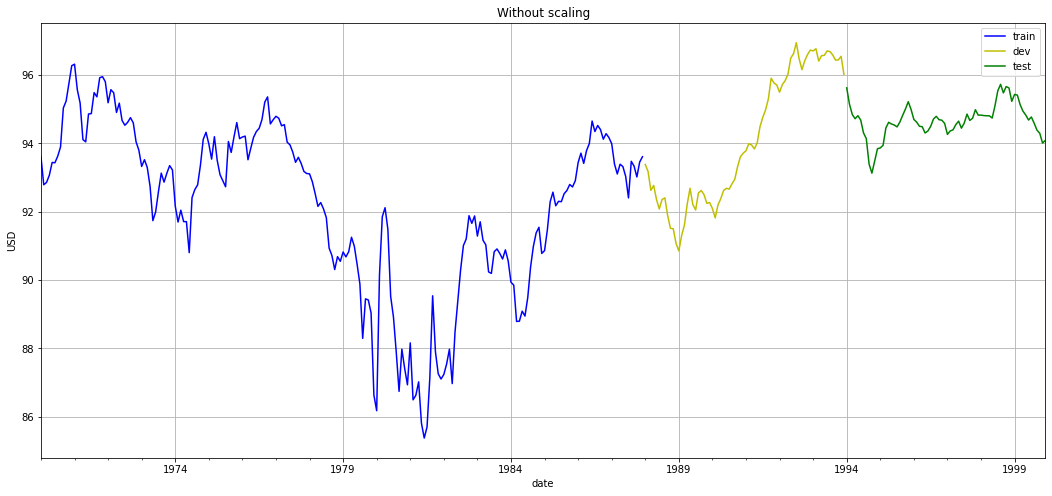

In [20]:
# Plot
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

ax = train.plot(x='date', y='price1', style='b-', grid=True)
ax = cv.plot(x='date', y='price1', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price1', style='g-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title("Without scaling")

Text(0.5, 1.0, 'With scaling')

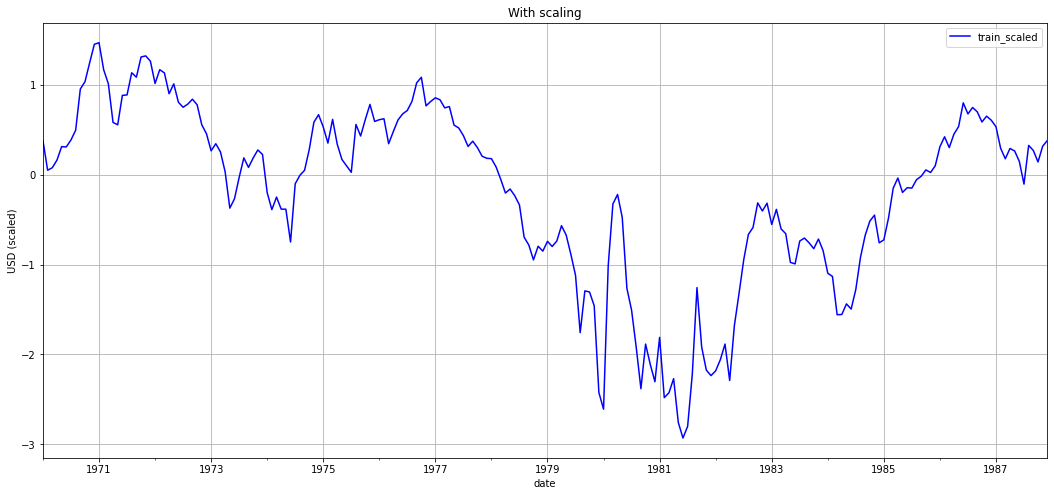

In [21]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

ax = train_scaled.plot(x='date', y='price1', style='b-', grid=True)
ax.legend(['train_scaled'])
ax.set_xlabel("date")
ax.set_ylabel("USD (scaled)")
ax.set_title("With scaling")

# Train the model using XGBoost

In [22]:
# Create the model
model = XGBRegressor(seed=model_seed,
                     n_estimators=n_estimators,
                     max_depth=max_depth,
                     learning_rate=learning_rate,
                     min_child_weight=min_child_weight,
                     subsample=subsample,
                     colsample_bytree=colsample_bytree,
                     colsample_bylevel=colsample_bylevel,
                     gamma=gamma)
X_train_scaled.drop(['date'],axis=1,inplace=True)
# Train the regressor
model.fit(X_train_scaled, y_train_scaled)

D:\anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=100, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=100, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

# Predict on train set

In [23]:
# Do prediction on train set
est_scaled = model.predict(X_train_scaled)
est = est_scaled * math.sqrt(scaler.var_[0]) + scaler.mean_[0]

# Calculate RMSE
print("RMSE on train set = %0.3f" % math.sqrt(mean_squared_error(y_train, est)))

# Calculate MAPE
print("MAPE on train set = %0.3f%%" % get_mape(y_train, est))

RMSE on train set = 0.491
MAPE on train set = 0.517%


Text(0.5, 1.0, 'Without scaling')

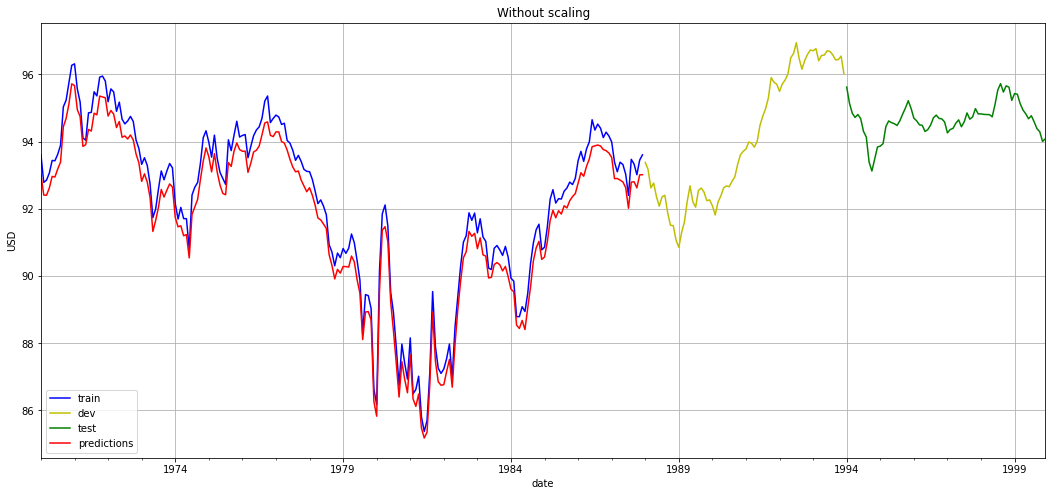

In [24]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'date': train['date']})

ax = train.plot(x='date', y='price1', style='b-', grid=True)
ax = cv.plot(x='date', y='price1', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price1', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_title('Without scaling')

# Predict on dev set

In [25]:
# Do prediction on test set
X_cv_scaled.drop(['date'],axis=1,inplace=True)
est_scaled = model.predict(X_cv_scaled)
cv['est_scaled'] = est_scaled
cv['est'] = cv['est_scaled'] * cv['price1_std'] + cv['price1_mean']

# Calculate RMSE
rmse_bef_tuning = math.sqrt(mean_squared_error(y_cv, cv['est']))
print("RMSE on dev set = %0.3f" % rmse_bef_tuning)

# Calculate MAPE
mape_bef_tuning = get_mape(y_cv, cv['est'])
print("MAPE on dev set = %0.3f%%" % mape_bef_tuning)

RMSE on dev set = 0.401
MAPE on dev set = 0.336%


D:\anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
D:\anaconda\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
D:\anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#

Text(0, 0.5, 'USD')

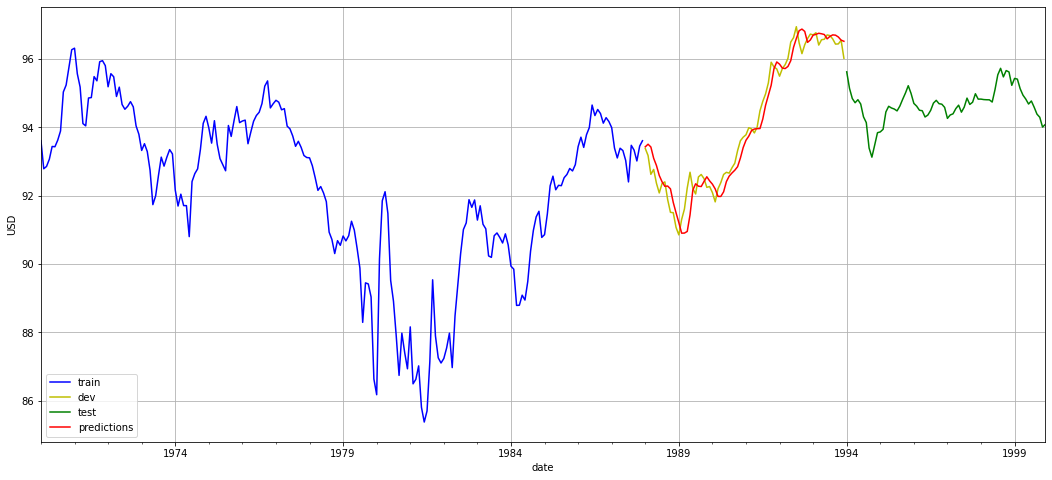

In [26]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

est_df = pd.DataFrame({'est': cv['est'], 
                       'y_cv': y_cv,
                       'date': cv['date']})

ax = train.plot(x='date', y='price1', style='b-', grid=True)
ax = cv.plot(x='date', y='price1', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price1', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to dev set')

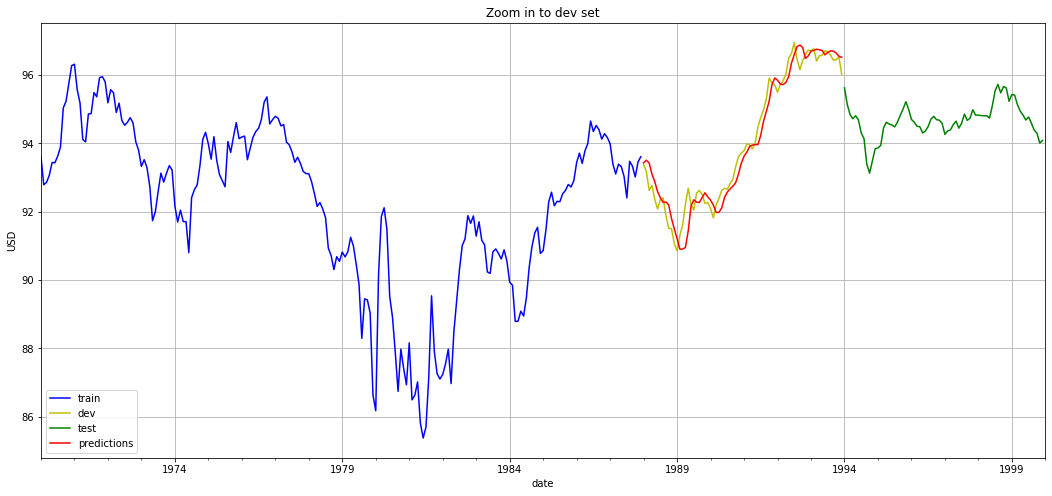

In [27]:
# Plot adjusted close over time, for dev set only
rcParams['figure.figsize'] = 18, 8 # width 10, height 8
ax = train.plot(x='date', y='price1', style='b-', grid=True)
ax = cv.plot(x='date', y='price1', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price1', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(1970, 1, 1), date(2000, 1, 1)])
ax.set_title("Zoom in to dev set")

The predictions capture the turn in directions with a slight lag

In [28]:
# View a list of the features and their importance scores
imp = list(zip(train[features], model.feature_importances_))
imp.sort(key=lambda tup: tup[1]) 
imp[-10:]

[('PCA27', 0.014302926),
 ('PCA18', 0.016469806),
 ('PCA13', 0.016533522),
 ('PCA19', 0.017039595),
 ('emp:_nondbles', 0.018501919),
 ('PCA12', 0.030194758),
 ('PCA26', 0.050785284),
 ('marco_h1', 0.071101904),
 ('PCA17', 0.16142908),
 ('price1_mean', 0.4296513)]

Importance features dominated by adj_close and volume

# Tuning N (no. of days to use as features)

In [29]:
d = {'N': [2, 3, 4, 5, 6, 7, 14],
     'rmse_dev_set': [1.225, 1.214, 1.231, 1.249, 1.254, 1.251, 1.498],
     'mape_pct_dev_set': [0.585, 0.581, 0.590, 0.601, 0.609, 0.612, 0.763]}
pd.DataFrame(d)

,N,rmse_dev_set,mape_pct_dev_set
0,2,1.225,0.585
1,3,1.214,0.581
2,4,1.231,0.590
3,5,1.249,0.601
4,6,1.254,0.609
5,7,1.251,0.612
6,14,1.498,0.763


Use N = 3 for lowest RMSE and MAPE

# Tuning XGBoost - n_estimators (default=100) and max_depth (default=3)

In [30]:
param_label = 'n_estimators'
param_list = range(10, 310, 10)

param2_label = 'max_depth'
param2_list = [2, 3, 4, 5, 6, 7, 8, 9]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['price1_mean'],
                                     cv['price1_std'],
                                     seed=model_seed,
                                     n_estimators=param, 
                                     max_depth=param2, 
                                     learning_rate=learning_rate, 
                                     min_child_weight=min_child_weight, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

D:\anaconda\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Minutes taken = 1.0054210424423218


,n_estimators,max_depth,rmse,mape_pct
0,10,2,0.388230,0.333697
1,10,3,0.394017,0.335948
2,10,4,0.399856,0.338649
3,10,5,0.401638,0.338753
4,10,6,0.403455,0.340407
...,...,...,...,...
235,300,5,0.421761,0.342890
236,300,6,0.427014,0.344466
237,300,7,0.429323,0.347374
238,300,8,0.427491,0.345461


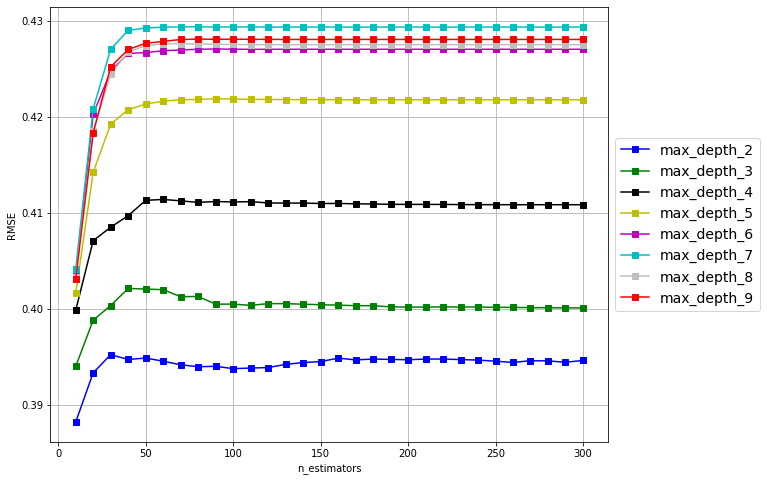

In [31]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [32]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
n_estimators_opt = temp['n_estimators'].values[0]
max_depth_opt = temp['max_depth'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
n_estimators_opt, max_depth_opt

min RMSE = 0.388
optimum params = 


(10, 2)

In [33]:
# Get optimum value for param and param2, using MAPE
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['n_estimators'].values[0], temp['max_depth'].values[0]

min MAPE = 0.333%
optimum params = 


(100, 2)

# Tuning XGBoost - learning_rate(default=0.1) and min_child_weight(default=1)

In [34]:
param_label = 'learning_rate'
param_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3]

param2_label = 'min_child_weight'
param2_list = range(5, 21, 1)

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['price1_mean'],
                                     cv['price1_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=param, 
                                     min_child_weight=param2, 
                                     subsample=subsample, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=gamma)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

D:\anaconda\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Minutes taken = 0.04728309313456217


,learning_rate,min_child_weight,rmse,mape_pct
0,0.001,5,0.383631,0.331355
1,0.001,6,0.383631,0.331355
2,0.001,7,0.383631,0.331355
3,0.001,8,0.383631,0.331355
4,0.001,9,0.383631,0.331355
...,...,...,...,...
107,0.300,16,0.398562,0.338939
108,0.300,17,0.404918,0.342176
109,0.300,18,0.404918,0.342176
110,0.300,19,0.397601,0.338460


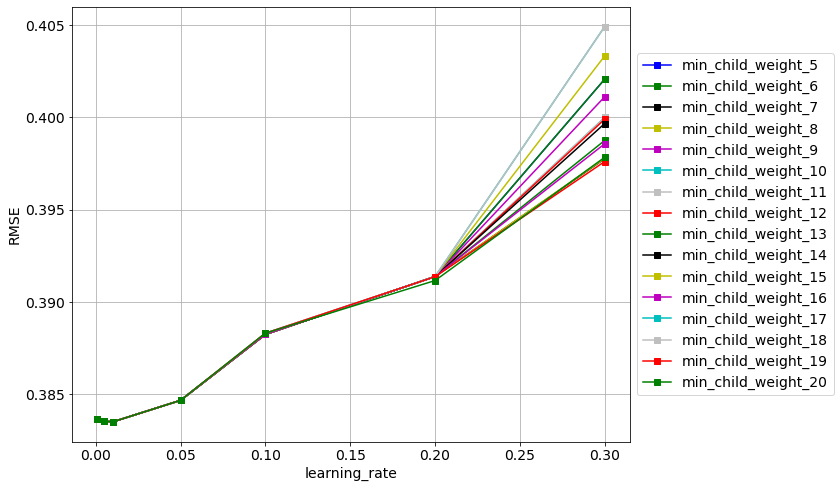

In [35]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [36]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
learning_rate_opt = temp['learning_rate'].values[0]
min_child_weight_opt = temp['min_child_weight'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
learning_rate_opt, min_child_weight_opt

min RMSE = 0.383
optimum params = 


(0.01, 5)

In [37]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['learning_rate'].values[0], temp['min_child_weight'].values[0]

min MAPE = 0.331%
optimum params = 


(0.001, 5)

# Tuning XGBoost - subsample(default=1) and gamma(default=0)

In [38]:
param_label = 'subsample'
param_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'gamma'
param2_list = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['price1_mean'],
                                     cv['price1_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=param, 
                                     colsample_bytree=colsample_bytree, 
                                     colsample_bylevel=colsample_bylevel, 
                                     gamma=param2)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

D:\anaconda\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Minutes taken = 0.04088387091954549


,subsample,gamma,rmse,mape_pct
0,0.1,0.1,0.382247,0.331185
1,0.1,0.2,0.382247,0.331185
2,0.1,0.3,0.382247,0.331185
3,0.1,0.4,0.382247,0.331185
4,0.1,0.5,0.382247,0.331185
...,...,...,...,...
95,1.0,0.6,0.383489,0.331743
96,1.0,0.7,0.383489,0.331743
97,1.0,0.8,0.383489,0.331743
98,1.0,0.9,0.383489,0.331743


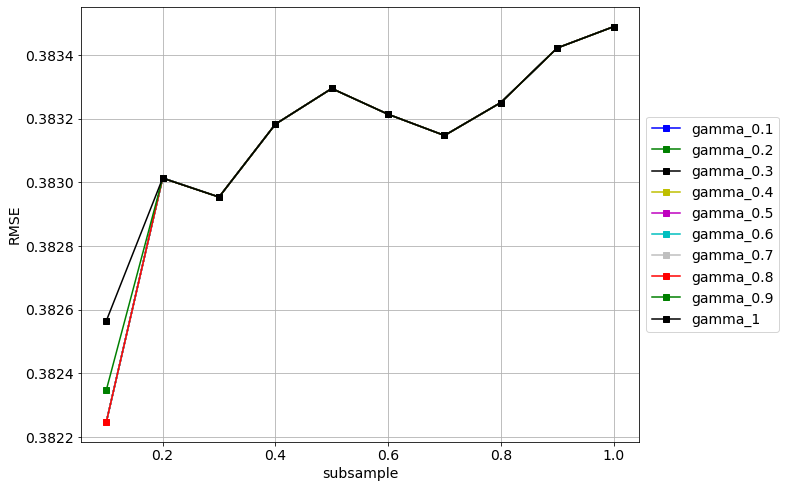

In [39]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [40]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
subsample_opt = temp['subsample'].values[0]
gamma_opt = temp['gamma'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
subsample_opt, gamma_opt

min RMSE = 0.382
optimum params = 


(0.1, 0.1)

In [41]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['subsample'].values[0], temp['gamma'].values[0]

min MAPE = 0.331%
optimum params = 


(0.1, 0.1)

# Tuning XGBoost - colsample_bytree(default=1) and colsample_bylevel(default=1)

In [42]:
param_label = 'colsample_bytree'
param_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

param2_label = 'colsample_bylevel'
param2_list = [0.5, 0.6, 0.7, 0.8, 0.9, 1]

error_rate = {param_label: [] , param2_label: [], 'rmse': [], 'mape_pct': []}
tic = time.time()
for param in tqdm_notebook(param_list):
#     print("param = " + str(param))
    
    for param2 in param2_list:
        # Train, predict and eval model
        rmse, mape, _ = train_pred_eval_model(X_train_scaled, 
                                     y_train_scaled, 
                                     X_cv_scaled, 
                                     y_cv, 
                                     cv['price1_mean'],
                                     cv['price1_std'],
                                     seed=model_seed,
                                     n_estimators=n_estimators_opt, 
                                     max_depth=max_depth_opt, 
                                     learning_rate=learning_rate_opt, 
                                     min_child_weight=min_child_weight_opt, 
                                     subsample=subsample_opt, 
                                     colsample_bytree=param, 
                                     colsample_bylevel=param2, 
                                     gamma=gamma_opt)
    
        # Collect results
        error_rate[param_label].append(param)
        error_rate[param2_label].append(param2)
        error_rate['rmse'].append(rmse)
        error_rate['mape_pct'].append(mape)
    
error_rate = pd.DataFrame(error_rate)
toc = time.time()
print("Minutes taken = " + str((toc-tic)/60.0))
error_rate   

D:\anaconda\lib\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



Minutes taken = 0.015721448262532554


,colsample_bytree,colsample_bylevel,rmse,mape_pct
0,0.5,0.5,0.383570,0.332511
1,0.5,0.6,0.383016,0.331284
2,0.5,0.7,0.383329,0.331507
3,0.5,0.8,0.382952,0.331320
4,0.5,0.9,0.382767,0.331282
5,0.5,1.0,0.382196,0.331065
6,0.6,0.5,0.382722,0.331581
7,0.6,0.6,0.382992,0.331615
8,0.6,0.7,0.382872,0.331496
9,0.6,0.8,0.382385,0.330960


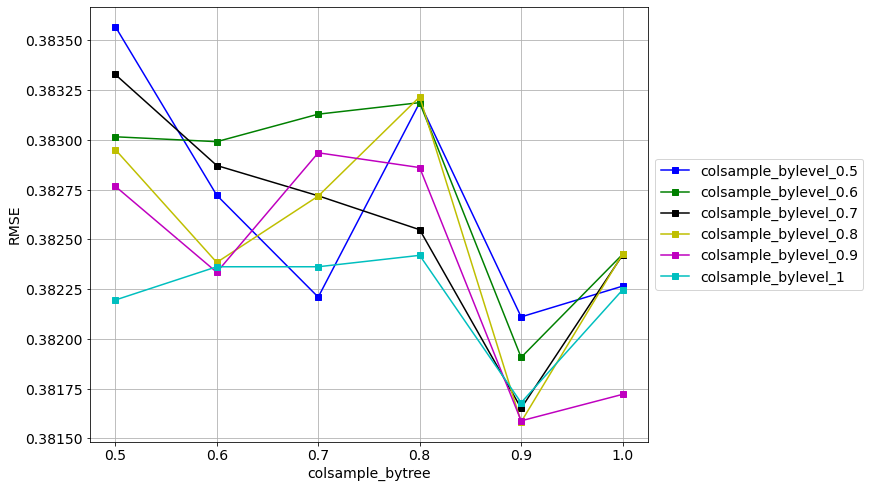

In [43]:
# Plot performance versus params
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
temp = error_rate[error_rate[param2_label]==param2_list[0]]
ax = temp.plot(x=param_label, y='rmse', style='bs-', grid=True)
legend_list = [param2_label + '_' + str(param2_list[0])]

color_list = ['r', 'g', 'k', 'y', 'm', 'c', '0.75']
for i in range(1,len(param2_list)):
    temp = error_rate[error_rate[param2_label]==param2_list[i]]
    ax = temp.plot(x=param_label, y='rmse', color=color_list[i%len(color_list)], marker='s', grid=True, ax=ax)
    legend_list.append(param2_label + '_' + str(param2_list[i]))

ax.set_xlabel(param_label)
ax.set_ylabel("RMSE")
matplotlib.rcParams.update({'font.size': 14})
plt.legend(legend_list, loc='center left', bbox_to_anchor=(1.0, 0.5)) # positions legend outside figure

In [44]:
# Get optimum value for param and param2
temp = error_rate[error_rate['rmse'] == error_rate['rmse'].min()]
colsample_bytree_opt = temp['colsample_bytree'].values[0]
colsample_bylevel_opt = temp['colsample_bylevel'].values[0]
print("min RMSE = %0.3f" % error_rate['rmse'].min())
print("optimum params = ")
colsample_bytree_opt, colsample_bylevel_opt

min RMSE = 0.382
optimum params = 


(0.9, 0.8)

In [45]:
# Get optimum value for param and param2, using MAPE
# We will use RMSE to decide the final optimum params to use
temp = error_rate[error_rate['mape_pct'] == error_rate['mape_pct'].min()]
print("min MAPE = %0.3f%%" % error_rate['mape_pct'].min())
print("optimum params = ")
temp['colsample_bytree'].values[0], temp['colsample_bylevel'].values[0]

min MAPE = 0.331%
optimum params = 


(0.9, 1.0)

# Tuned params

In [46]:
d = {'param': ['n_estimators', 'max_depth', 'learning_rate', 'min_child_weight', 'subsample', 'colsample_bytree', 'colsample_bylevel', 'gamma', 'rmse', 'mape_pct'],
     'original': [n_estimators, max_depth, learning_rate, min_child_weight, subsample, colsample_bytree, colsample_bylevel, gamma, rmse_bef_tuning, mape_bef_tuning],
     'after_tuning': [n_estimators_opt, max_depth_opt, learning_rate_opt, min_child_weight_opt, subsample_opt, colsample_bytree_opt, colsample_bylevel_opt, gamma_opt, error_rate['rmse'].min(), error_rate['mape_pct'].min()]}
tuned_params = pd.DataFrame(d)
tuned_params = tuned_params.round(3)
tuned_params

,param,original,after_tuning
0,n_estimators,100.000,10.000
1,max_depth,3.000,2.000
2,learning_rate,0.100,0.010
3,min_child_weight,1.000,5.000
4,subsample,1.000,0.100
5,colsample_bytree,1.000,0.900
6,colsample_bylevel,1.000,0.800
7,gamma,0.000,0.100
8,rmse,0.401,0.382
9,mape_pct,0.336,0.331


# Final model

In [47]:
X_sample_scaled.drop(["date"],axis=1,inplace=True)

D:\anaconda\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [48]:
X_train_cv_scaled.drop(["date"],axis=1,inplace=True)

In [49]:
rmse, mape, est = train_pred_eval_model(X_train_cv_scaled, 
                             y_train_cv_scaled, 
                             X_sample_scaled, 
                             y_sample, 
                             test['price1_mean'],
                             test['price1_std'],
                             seed=model_seed,
                             n_estimators=n_estimators_opt,
                             max_depth=max_depth_opt,
                             learning_rate=learning_rate_opt,
                             min_child_weight=min_child_weight_opt,
                             subsample=subsample_opt,
                             colsample_bytree=colsample_bytree_opt,
                             colsample_bylevel=colsample_bylevel_opt,
                             gamma=gamma_opt)

# Calculate RMSE
print("RMSE on test set = %0.3f" % rmse)

# Calculate MAPE
print("MAPE on test set = %0.3f%%" % mape)

RMSE on test set = 0.386
MAPE on test set = 0.304%


Text(0, 0.5, 'USD')

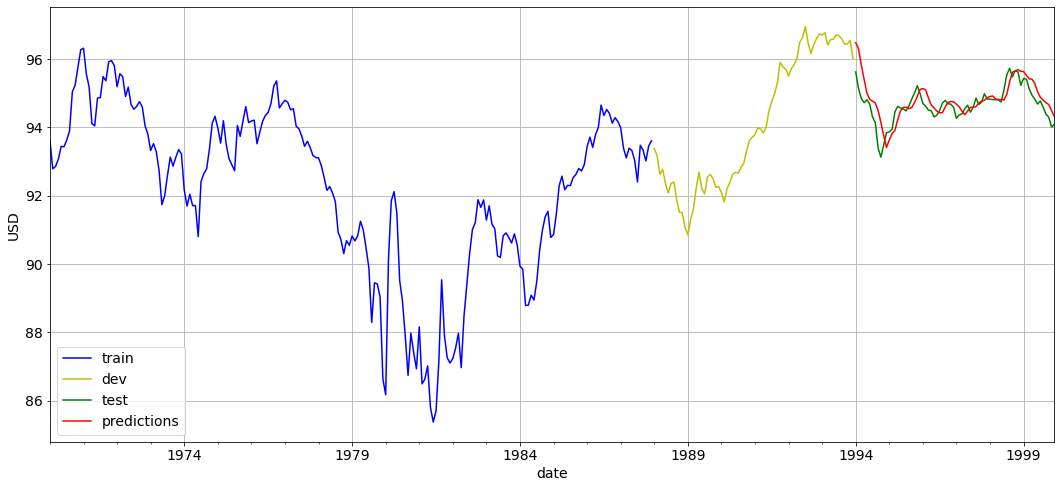

In [50]:
# Plot adjusted close over time
rcParams['figure.figsize'] = 18, 8 # width 10, height 8

est_df = pd.DataFrame({'est': est, 
                       'y_sample': y_sample,
                       'date': test['date']})

ax = train.plot(x='date', y='price1', style='b-', grid=True)
ax = cv.plot(x='date', y='price1', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price1', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")

Text(0.5, 1.0, 'Zoom in to test set')

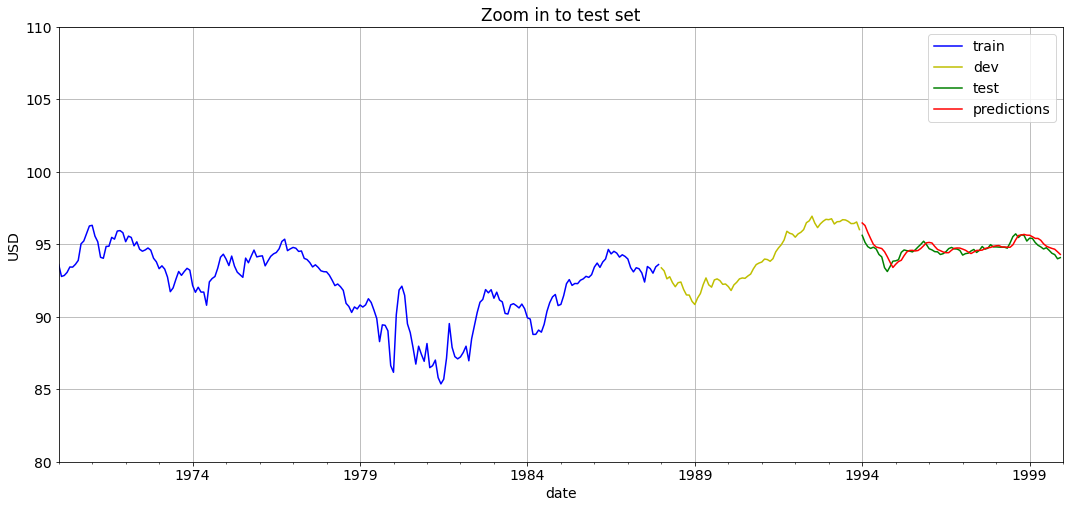

In [51]:
# Plot adjusted close over time, for test set only
rcParams['figure.figsize'] = 18, 8 # width 10, height 8
ax = train.plot(x='date', y='price1', style='b-', grid=True)
ax = cv.plot(x='date', y='price1', style='y-', grid=True, ax=ax)
ax = test.plot(x='date', y='price1', style='g-', grid=True, ax=ax)
ax = est_df.plot(x='date', y='est', style='r-', grid=True, ax=ax)
ax.legend(['train', 'dev', 'test', 'predictions'])
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(1970, 1, 1), date(2000, 1, 1)])
ax.set_ylim([80, 110])
ax.set_title("Zoom in to test set")

Similar to dev set, the predictions capture turns in direction with a slight lag

In [53]:
# Plot adjusted close over time, only for test set
%matplotlib auto
rcParams['figure.figsize'] = 18, 4 # width 18, height 4
matplotlib.rcParams.update({'font.size': 14})

ax = test.plot(x='date', y='price1', style='gx-', grid=True)
ax = est_df.plot(x='date', y='est', style='rx-', grid=True, ax=ax)
ax.legend(['test', 'predictions using xgboost'], loc='upper left')
ax.set_xlabel("date")
ax.set_ylabel("USD")
ax.set_xlim([date(1994, 1, 1), date(2000, 1, 1)])
ax.set_ylim([90, 100])

Using matplotlib backend: Qt5Agg


(90.0, 100.0)

In [55]:
# Save as csv
test_xgboost = est_df
test_xgboost.to_csv("Out/DataPre_3M_TranPre_3M_Price1_xgboost.csv")

# Findings
* By scaling the features properly, we can get good results for our predictions
* RMSE and MAPE changed very little with hyperparameter tuning
* The final RMSE and MAPE for test set are 1.162 and 0.58% respectively